In [1]:
import pandas as pd
import re
import os
import numpy as np
import gensim
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Convolution1D, MaxPooling1D, LSTM
from keras.layers import Input, Conv1D, MaxPool1D, Bidirectional, GRU
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [3]:
def preprocess(text, remove_stop_words = False, stem=True):
    # remove link
    text = re.sub(r"(http?\://|https?\://|www)\S+", " ", str(text).lower()).strip()
    # remove newlines
    text = re.sub(r'\n', ' ', text)
    # remove puctuations and special characters
    text = re.sub(r'\W+', ' ', text)
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # remove first space
    text = re.sub(r'^\s+', '', text)
    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    if remove_stop_words or stem:
        tokens = []
        for token in text.split():
            if remove_stop_words:
                if token not in stop_words:
                    if stem:
                        tokens.append(stemmer.stem(token))
                    else:
                        tokens.append(token)
            else:
                if stem:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
        return(" ".join(tokens))
    else:
        return(text)

In [4]:
def get_w2v_model(embedding_dim = 200, window_size=5, save_vectors = False, path = None):
    w2v_model = gensim.models.word2vec.Word2Vec(size=embedding_dim, 
                                                window=window_size, 
                                                min_count=10, 
                                                workers=8)
    w2v_model.build_vocab(documents)
    words = w2v_model.wv.vocab.keys()
    w2v_model.train(documents, total_examples=len(documents), epochs=64)
    if save_vectors:
        w2v_model.save(path)
        
    return(w2v_model)

In [5]:
def get_embedding_matrix(method = "word2vec", has_model=False, embedding_dim=200, save_vectors=False, path=None):
    if method == "word2vec":
        if not has_model:
            w2v_model = gensim.models.word2vec.Word2Vec(size=embedding_dim, 
                                                    window=7, 
                                                    min_count=10, 
                                                    workers=8)
            w2v_model.build_vocab(documents)
            words = w2v_model.wv.vocab.keys()
            w2v_model.train(documents, total_examples=len(documents), epochs=32)
            if save_vectors:
                w2v_model.save(path)
        
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) #Return a new array of given shape and type, filled with zeros.
        for word, i in tokenizer.word_index.items():
            if word in w2v_model.wv:
                embedding_matrix[i] = w2v_model.wv[word]
    
    if method == "glove":
        #https://www.kaggle.com/hamishdickson/bidirectional-lstm-in-keras-with-glove-embeddings
        embeddings_index = {}
        f = open(path, encoding='UTF-8')
        for line in f:
            values = line.split()
            word = values[0] ## The first entry is the word
            coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
            embeddings_index[word] = coefs
        f.close()

        #max_features = 50000
        max_features = vocab_size - 1
        num_words = min(max_features, vocab_size - 1) + 1
        #print(num_words)

        # first create a matrix of zeros, this is our embedding matrix
        embedding_matrix = np.zeros((num_words, embedding_dim))

        # for each word in out tokenizer lets try to find that work in our w2v model
        for word, i in tokenizer.word_index.items():
            if i > max_features:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # we found the word - add that words vector to the matrix
                embedding_matrix[i] = embedding_vector
            #else:
                # doesn't exist, assign a random vector
            #    embedding_matrix[i] = np.random.randn(embedding_dim)
    
    return(embedding_matrix)

In [6]:
#https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
import keras.backend as K
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

## W2V training data

In [7]:
## W2V training data
rt = pd.read_csv("../data/w2v_training_data_conpoli&elect_seeduser1-5000.csv", encoding = "UTF-8")

In [8]:
%%time
rt.text = rt.text.apply(lambda x: preprocess(x, remove_stop_words = False, stem=False))

CPU times: user 2min 7s, sys: 476 ms, total: 2min 7s
Wall time: 2min 7s


In [9]:
documents = [_text.split() for _text in rt.text] 

In [ ]:
w2v_model = get_w2v_model(embedding_dim = 200, window_size=5, 
                          save_vectors = True, 
                          path = "../models/w2v_training_data_conpoli&elect_seeduser1-5000_not-stem_win5.w2v")

In [17]:
del [rt]

## Model training

In [7]:
df = pd.read_csv("../data/cong_politician_tweets_2020-3-12-2021-5-28_text_party_balanced.csv", encoding = "UTF-8")

In [7]:
## check labels
df['party'].value_counts()

R    1252460
D    1252460
Name: party, dtype: int64

In [9]:
## check NAs
df['party'].isna().sum()

0

In [10]:
## drop NAs
df = df[df['party'].notna()]

In [11]:
%%time
df.text = df.text.apply(lambda x: preprocess(x, remove_stop_words = False, stem=False))

CPU times: user 1min 4s, sys: 198 ms, total: 1min 5s
Wall time: 1min 5s


In [8]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state = 42)

In [9]:
%%time
## use all words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
print(list(tokenizer.word_index.items())[0:10])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

[('the', 1), ('to', 2), ('and', 3), ('of', 4), ('in', 5), ('a', 6), ('for', 7), ('s', 8), ('is', 9), ('i', 10)]
Total words 395687
CPU times: user 41.8 s, sys: 47.1 ms, total: 41.9 s
Wall time: 41.9 s


In [18]:
%%time
#print(tokenizer.texts_to_sequences(df.text)[0:5]) # transform to numerical labels
SEQUENCE_LENGTH = 50
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH) # pad a window to a same lenght
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 48.5 s, sys: 381 ms, total: 48.9 s
Wall time: 48.8 s


In [11]:
encoder = LabelEncoder()
encoder.fit(df_train.party.tolist())

y_train = encoder.transform(df_train.party.tolist()) # transform non-numerical data to numerical labels
y_test = encoder.transform(df_test.party.tolist())

ylist = list(y_train)
print(set(ylist))

y_train = y_train.reshape(-1,1) # -1 means unknown
y_test = y_test.reshape(-1,1)

print(y_train[0:5])
print("y_train",y_train.shape)
print("y_test",y_test.shape)

{0, 1}
[[1]
 [1]
 [0]
 [0]
 [1]]
y_train (2003936, 1)
y_test (500984, 1)


In [22]:
w2v_model = gensim.models.Word2Vec.load("../models/w2v_training_data_conpoli&elect_seeduser1-5000_not-stem_win5.w2v")

In [24]:
embedding_matrix = np.zeros((vocab_size, 200)) #Return a new array of given shape and type, filled with zeros.
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [25]:
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [35]:
from keras.layers import CuDNNLSTM, Activation, CuDNNGRU, Conv1D
inp = Input(shape=(SEQUENCE_LENGTH,))
x = embedding_layer(inp)
x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(x)
#x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = AttentionWithContext(name='attention_vec')(x)
x = Dense(64, activation="relu")(x)
#x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
model.summary()
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 200)           79137400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 400)           641600    
_________________________________________________________________
attention_vec (AttentionWith (None, 400)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 79,965,529
Trainable params: 828,129
Non-trainable params: 79,137,400
_________________________________________

In [37]:
%%time
BATCH_SIZE = 512
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs = 64,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1803542 samples, validate on 200394 samples
Epoch 1/64
1803542/1803542 [==============================] - 305s 169us/step - loss: 0.3678 - accuracy: 0.8224 - val_loss: 0.3137 - val_accuracy: 0.8522
Epoch 2/64
1803542/1803542 [==============================] - 303s 168us/step - loss: 0.3175 - accuracy: 0.8490 - val_loss: 0.2978 - val_accuracy: 0.8603
Epoch 3/64
1803542/1803542 [==============================] - 305s 169us/step - loss: 0.3035 - accuracy: 0.8565 - val_loss: 0.2920 - val_accuracy: 0.8631
Epoch 4/64
1803542/1803542 [==============================] - 305s 169us/step - loss: 0.2953 - accuracy: 0.8607 - val_loss: 0.2874 - val_accuracy: 0.8662
Epoch 5/64
1803542/1803542 [==============================] - 308s 171us/step - loss: 0.2895 - accuracy: 0.8635 - val_loss: 0.2853 - val_accuracy: 0.8671
Epoch 6/64
1803542/1803542 [==============================] - 309s 171us/step - loss: 0.2851 - accuracy: 0.8658 - val_loss: 0.2813 - val_accuracy: 0.8694
Epoch 7/64
1803542/1803

In [38]:
%%time
y_proba = model.predict(X_test, verbose=1, batch_size=BATCH_SIZE)
y_pred = (y_proba > 0.5).astype("int32")
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
f1s = f1_score(y_test, y_pred, average='binary')
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])
print("F1 Score:",f1s)

500984/500984 [==============================] - 31s 62us/step

ACCURACY: 0.8741896152496338
LOSS: 0.2760573265236447
F1 Score: 0.8764808133621542
CPU times: user 1min 23s, sys: 6.41 s, total: 1min 29s
Wall time: 1min 4s


In [39]:
y_pred = (y_proba > 0.5).astype("int32")

In [71]:
f1s = f1_score(y_test, y_pred, average='binary')

In [72]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([88555, 71442]))

In [31]:
from sklearn.metrics import roc_curve
#y_proba = model.predict(X_test, verbose=1, batch_size=8000)
y_pred_keras = y_proba.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

/home/lingshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


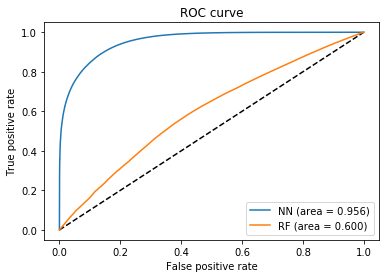

In [34]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='NN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.

In [12]:
#model.save("../models/cong_politician_2020-3-12-2021-5-28_balanced_pre-w2v.h5")
import pickle
#pickle.dump(tokenizer, open("../models/cong_politician_2020-3-12-2021-5-28_balanced_pre-w2v_tokenizer.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("../models/cong_politician_2020-3-12-2021-5-28_balanced_pre-w2v_y-encoder.pkl", "wb"), protocol=0)

## Get Attention Weights
https://stackoverflow.com/questions/52152054/keras-how-to-display-attention-weights-in-lstm-model

In [76]:
g = model.layers[3].get_config()
layer_weights = model.layers[3].get_weights()
print(len(layer_weights))

new_model = Model(inputs=model.input, outputs=model.layers[2].output)
output_before_att = new_model.predict(X_test) #extract layer output

3


In [78]:
eij = np.tanh(np.dot(output_before_att, layer_weights[0]) + layer_weights[1]) #Eq.(5) in the paper
eij = np.dot(eij, layer_weights[2]) #Eq.(6)
eij = eij.reshape((eij.shape[0], eij.shape[1])) # reshape the vector
ai = np.exp(eij) #Eq.(6)
weights = ai / np.sum(ai) # Eq.(6)

In [84]:
key_list = list(tokenizer.word_index.keys())
val_list = list(tokenizer.word_index.values())

index_list = []
words_list = []
weights_list = []
for t in range(len(X_test)):
    for i in range(len(X_test[t])):
        if X_test[t][i] != 0:
            index_list.append(X_test[t][i])
            words_list.append(key_list[val_list.index(X_test[t][i])])
            weights_list.append(weights[t][i])

In [82]:
X_test[0:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  4027,    14,    36,
           25,     7,   368,     2,    73,     1,   431,    14,    50,
            2,    73,    17,   461,    65],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    26,   664,   178,   480,    47,
         5859,     3,   664,   178,   480,     7,  2586,    85,   664,
          178,   480,     2,    64,   296,     2,   542,   136,     1,
         1902,    31,    46,    26,   235],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [83]:
df.groupby(['Animal']).mean()

93